2020-06-27 00:00:00
0.006255620283848771
0.09974073718432351
0.06782800011139889
0.21875224123229925
0.05626596317717162
0.0441108030998968
0.012806175823382995
0.0383127417945838
0.0394884835444276
GA
0.09494701376938852
0.010385351188849413
0.06616356947457787
0.08389643006637565
0.0260423206736605
0.03720672250263465
0.06858271029549795
0.0370972752690923
0.04861345318640778
0.0241601981467967
0.0480225988700565
0.016153890062218162
0.020934241852064692
0.05510800846037378
0.05483572782678177
0.15805216943810105
0.012964302942595273
0.06996610974398826
0.024274621986105437
0.05865275216760171
0.02050959421201636
0.014695890920936292
0.028813450555092088
0.09898308831656903
0.0254260620043818
0.043201950214771315
0.07551253777668872
0.04607554245914814
0.042133305744510255
0.018482707326143547
0.1544214234535467
0.057984306532151225
0.07389219929737388
0.12731160359079602
0.12212190694563868
0.04328857674034291
0.007702034716634096
0.05382491346789562
0.03956053050836937
0.0149079803

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in power
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in power
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
p

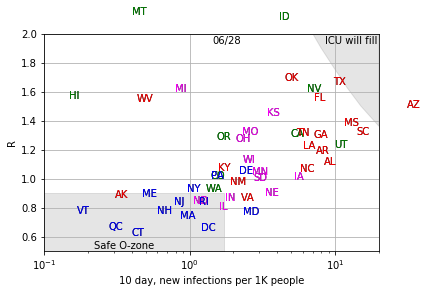

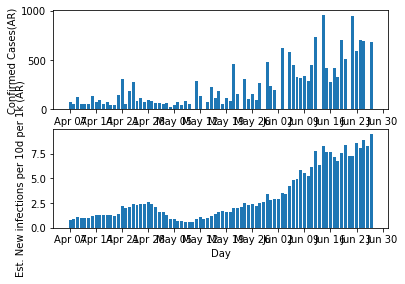

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Mon Apr 20 10:16:43 2020

@author: dblake
"""

import os
import re
import matplotlib.pyplot as plt
import csv as commafile
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import datetime as datetime
import scipy as signal
import requests


def num_density(ccases,tcases,numdays,daystop):
    density=np.zeros(numdays)
    for j in np.arange(11,numdays+1):
        ppnow=(ccases[j-2]-ccases[j-12])/(tcases[j-2]-tcases[j-12])
        if j>=daystop:
             ppnow=(ccases[daystop-2]-ccases[daystop-12])/(tcases[daystop-2]-tcases[daystop-12])
        density[j-1]=8.56*(ccases[j-2]-ccases[j-12])*np.power(ppnow/0.19,0.5)
    return(density)

def calc_r(ccases,tcases,numdays,daypast,daystop):
    ppos=np.zeros(numdays)
    cdiff=np.diff(ccases)
    for i in np.arange(numdays-11):
        ppos[i+10]=(ccases[i+10]-ccases[i])/(tcases[i+10]-tcases[i])
#    print(ppos)
    filt=np.hamming(10)
    # get the two week ratio    
    sum1=np.sum(np.multiply(cdiff[numdays-12-daypast:numdays-daypast-2],filt))
    sum2=np.sum(np.multiply(cdiff[numdays-26-daypast:numdays-16-daypast],filt))
    if np.isnan(sum1/sum2):
        sum1=np.sum(np.multiply(cdiff[numdays-13-daypast:numdays-daypast-3],filt))
        sum2=np.sum(np.multiply(cdiff[numdays-27-daypast:numdays-17-daypast],filt))
    
    ratio1=sum1/sum2
    # get the two week test positivity
    sum3=ppos[numdays-2-daypast]
    sum4=ppos[numdays-16-daypast]
    ratio=ratio1
    pratio=sum3/sum4
    if np.isnan(sum3/sum4):
        sum3=ppos[numdays-3-daypast]
        sum4=ppos[numdays-17-daypast]
        pratio=sum3/sum4
    if numdays-3-daypast>daystop:
        sum3=ppos[daystop]
        sum4=ppos[daystop-14]
        pratio=sum3/sum4
    if sum3<0.5 and numdays-3-daypast<daystop:
        ratio=ratio1*np.power(pratio,0.5)
    sum3=ppos[numdays-2-daypast]
    if numdays-3-daypast>=daystop:
        ratio=ratio1
        sum3=ppos[daystop-3-daypast]
        
    re=np.power(ratio,5.2/14)
    sum3=ppos[numdays-3-daypast]
    if numdays-daypast>=daystop:
        ratio=ratio1
        # use terminal positivity
        sum3=(ccases[daystop-2]-ccases[daystop-12])/(tcases[daystop-2]-tcases[daystop-12])
    print(sum3)
    sum1=8.56*(ccases[numdays-3-daypast]-ccases[numdays-daypast-13])*np.power(sum3/0.19,0.5)
#    if numdays>daystop:
#        sum1=6.06*(ccases[numdays-2-daypast]-ccases[numdays-daypast-12])
        
    sum2=tcases[numdays-2-daypast]-tcases[numdays-12-daypast]
    # now account for differences in testing and true prevalence
    # if testing positivity were 19%, the scaling factor is 11.2
    return(re,sum1,sum2,sum3)    

pop_v=np.array([731.0,4903.0,3017.0,7278.0,39512.0,5758.0,3565.0,973.0,
    21477.0,10617.0,1415.0,3155.0,1787.0,12671.0,6732.0,2913.0,4467.0,
    4648.0,6892.0,6045.0,1344.0,9986.0,5639.0,6137.0,2976.0,1068.0,
    10488.0,762.0,1934.0,1359.0,8882.0,2096.0,3080.0,19453.0,11689.0,
    3956.0,4217.0,12801.0,1059.0,5148.0,884.0,6829.0,28995.0,3205.0,
    8535.0,623.0,7614.0,5822.0,1792.0,578.0,704.7,8485.0,156.9])

st_v=['AK','AL','AR','AZ','CA','CO','CT','DE','FL','GA','HI','IA','ID','IL','IN','KS','KY','LA',
               'MA','MD','ME','MI','MN','MO','MS','MT','NC','ND','NE','NH','NJ','NM','NV','NY','OH',
               'OK','OR','PA','RI','SC','SD','TN','TX','UT','VA','VT','WA','WI','WV','WY','DC','QC','PE']

pol_v=['R','R','R','R','D','D','D','D','R','R','D','R','R','D','R','D','D','D',
               'R','R','D','D','D','R','R','D','D','R','R','R','D','D','D','D','R',
               'R','D','D','D','R','R','R','R','R','D','R','D','D','R','R','D','O','O']

stc_v=['red','red','red','red','green','green','blue','blue','red','red','green','magenta','green','magenta','magenta','magenta','red','red',
               'blue','blue','blue','magenta','magenta','magenta','red','green','red','magenta','magenta','blue','blue','red','green','blue','magenta',
               'red','green','blue','blue','red','magenta','red','red','green','red','blue','green','magenta','red','green','blue','blue','blue']

    
os.chdir(r'/Users/hugh/Dropbox/COVID') 

canada_csv=r'https://sante-infobase.canada.ca/src/data/covidLive/covid19.csv'
# canada data https://sante-infobase.canada.ca/src/data/covidLive/covid19.csv
today=np.datetime64('today')
daypast=0
us_pos=0
us_neg=0
st_pos=np.zeros(52)
st_neg=np.zeros(52)

st_pp2=np.zeros(52)
st_pc2=np.zeros(52)
j=0

canada_csv=r'https://sante-infobase.canada.ca/src/data/covidLive/covid19.csv'
us_csv=r'https://covidtracking.com/api/v1/states/daily.csv'

startday=np.datetime64('2020-03-21')
numdays=1+int((np.datetime64('today')-np.datetime64('2020-03-21'))/np.timedelta64(1,'D'))
datasize=numdays
stdata=np.zeros((55,datasize))
sttdata=np.zeros((55,datasize))


# grab Quebec data
with requests.Session() as s:
    download = s.get(canada_csv)
    decoded_content = download.content.decode('utf-8')

    cr = commafile.reader(decoded_content.splitlines(), delimiter=',')
    for row in cr:
        if len(row)>=2:
            if (row[1]=='Quebec'):
            # confirmed is 4, tested is 8, date is  3
                cday=pd.to_datetime(row[3],format='%d-%m-%Y') 
                cday64=np.datetime64(cday)
                day_diff=int((cday64-startday)/np.timedelta64(1,'D'))
                if (day_diff>=0):
                    stdata[51,day_diff]=int(row[4])
                    sttdata[51,day_diff]=int(row[8])
            if (row[1]=='Prince Edward Island'):
            # confirmed is 4, tested is 8, date is  3
                cday=pd.to_datetime(row[3],format='%d-%m-%Y') 
                cday64=np.datetime64(cday)
                day_diff=int((cday64-startday)/np.timedelta64(1,'D'))
                if (day_diff>=0):
                    stdata[52,day_diff]=int(row[4])
                    sttdata[52,day_diff]=int(row[8])
            
# grab US state data
foo=0
with requests.Session() as s:
    download = s.get(us_csv)
    decoded_content = download.content.decode('utf-8')

    cr = commafile.reader(decoded_content.splitlines(), delimiter=',')
    for row in cr:
        if re.search('2020',row[0]):
            cday=pd.to_datetime(row[0],format='%Y%m%d')
            if foo==0: 
                print(cday)
                foo=1
            day_diff=int((np.datetime64(cday)-startday)/np.timedelta64(1,'D'))
            for k in np.arange(51):
                if (row[1]==st_v[k]):
                    if (day_diff>=0):
                        if (row[2]) and (row[3]):
                            stdata[k,day_diff]=int(row[2])
                            sttdata[k,day_diff]=int(row[2])+int(row[3])

                    
# this section corrects for weird data dumps in state data, when a state decides to report
# a huge number of probable positives from times in the past all in one day, for example,
# or changes its antibody reporting from regular cases to antibody cases
for k in np.arange(36):
    sttdata[9,66-k]=sttdata[9,66-k]-(74189+9500)*np.power((36-k)/36.0,2)

for k in np.arange(36):
    sttdata[21,62-k]=sttdata[21,62-k]-(20866+17000)*np.power((36-k)/36.0,2)

#for k in np.arange(numdays-76):
#    stdata[21,k+76]=stdata[21,k+76]-5014

for k in np.arange(numdays-73):
    stdata[18,k+73]=stdata[18,k+73]-3749

for k in np.arange(36):
    sttdata[39,81-k]=sttdata[39,81-k]-(22475+4000)*np.power((36-k)/36.0,2)


# this is the section when you mark the day when a state had free testing, no criteria    
daytest=np.zeros(55)
for i in np.arange(55):
    daytest[i]=500

daytest[9]=51
daytest[8]=54
daytest[33]=75
daytest[22]=76
daytest[46]=77

r_v=np.zeros(55)
cs_v=np.zeros(55)
st_pp=np.zeros(55)
st_pc=np.zeros(55)

for i in np.arange(53):
    if i==9: print('GA')
    r_v[i],cs_v[i],st_pc[i],st_pp[i]=calc_r(stdata[i,:],sttdata[i,:],numdays,daypast,int(daytest[i]))


for k in np.arange(53):
    st_pc[k]=st_pc[k]/pop_v[k]
    cs_v[k]=(cs_v[k]/pop_v[k])
    

# adjust date and numdays if after 6:10pm
t1=pd.Timestamp(np.datetime64('now'))
dayplot=today-daypast*np.timedelta64(1,'D')
if (t1.hour>=22 and t1.minute>10) or t1.hour>22:
    numdays=numdays+1
    dayplot=today-(daypast-1)*np.timedelta64(1,'D')

# This section makes the O-zone plot
fig1,ax = plt.subplots()
ax.fill_between([0.01*8.56,0.2*8.56],[0.9,0.9],facecolor='black',color='black',alpha=0.1)
#plt.fill_between([3,10.0],[1.5,1.5],facecolor='black',color='black',alpha=0.2)
ax.text(0.353,0.54,'Safe O-zone',verticalalignment='center',horizontalalignment='center')
ax.text(12.8,1.95,'ICU will fill',verticalalignment='center',horizontalalignment='center')



daydt=dayplot.astype(datetime.datetime)
daytext=daydt.strftime('%m/%d')
ax.text(1.8,1.95,daytext,verticalalignment='center',horizontalalignment='center')

#text(4.5,0.25,'Bad ICU',verticalalignment='center',horizontalalignment='center')
colorplot=1
for k in np.arange(53):
    plt.text(cs_v[k],r_v[k],st_v[k],verticalalignment='center', horizontalalignment='center')    #if pol_v[k]=='R':
    if (colorplot):
        plt.text(cs_v[k],r_v[k],st_v[k],color=stc_v[k],verticalalignment='center', horizontalalignment='center')    #if pol_v[k]=='R':
        
    #     plt.text(cs_v[k],r_v[k],st_v[k],color='r',verticalalignment='center', horizontalalignment='center')
    #if pol_v[k]=='D':
    #     plt.text(cs_v[k],r_v[k],st_v[k],color='b',verticalalignment='center', horizontalalignment='center')
uplinex=[7,8,10,11,12,15,20]
upliney=[2.0,1.9,1.75,1.69,1.63,1.5,1.36]        
topliney=[80,80,80,80,80,80,80]
ax.fill_between(uplinex,upliney,topliney,facecolor='black',color='black',alpha=0.1)
ax.semilogx()
ax.set_xlabel('10 day, new infections per 1K people')
ax.set_ylabel('R')

# these for long running plot
ax.set_xlim(0.1,20)
ax.set_ylim(0.5,2.0)


ax.grid()

# A console print out of R, density, test positivity, and tests per person 

print('ST  Dens  R   PPos  ')
for i in np.arange(53):
    print ("%s %4.1f %4.2f %3.1f" % (st_v[i],cs_v[i],r_v[i],100*st_pp[i]))
    
    
# predictions when the O-zone will be reached for console
for i in np.arange(52):
    if r_v[i]<0.9 and cs_v[i]>0.2:
        days=int(5.2*np.log(6.02*0.2/cs_v[i])/np.log(r_v[i]))-daypast
        dayozone=today+days*np.timedelta64(1,'D')
        dtozone=pd.to_datetime(dayozone)
        print ("%s %s" % (st_v[i],dtozone.strftime('%m-%d')))



# st_v=['AK','AL','AR','AZ','CA','CO','CT','DE','FL','GA','HI','IA','ID','IL','IN','KS','KY','LA',
#                'MA','MD','ME','MI','MN','MO','MS','MT','NC','ND','NE','NH','NJ','NM','NV','NY','OH',
#                'OK','OR','PA','RI','SC','SD','TN','TX','UT','VA','VT','WA','WI','WV','WY','DC','QC']
# igraph here chooses the state for the graph
state='AR'
for i in np.arange(52):
    if st_v[i]==state:
        igraph=int(i)



xaxis1='Date'
xaxis2='Date'
yaxis1='Confirmed Cases'+'('+st_v[igraph]+')'
yaxis2='Est. New infections per 10d per 1k '+'('+st_v[igraph]+')'

stdiff=np.diff(stdata[igraph,:])
stdensity=num_density(stdata[igraph,:],sttdata[igraph,:],numdays,int(daytest[igraph]))/pop_v[igraph]

lenplot=int((np.datetime64('today')-np.datetime64('2020-04-07'))/np.timedelta64(1,'D'))
startday=np.datetime64('today')-lenplot*np.timedelta64(1,'D')
t1=pd.Timestamp(np.datetime64('now'))
if (t1.hour>=22 and t1.minute>10) or t1.hour>22:
    lenplot=lenplot+1

fig1, (ax1,ax2) = plt.subplots(2,1)
date = np.array(startday)
usx=date+np.arange(lenplot)
pv=stdiff[numdays-lenplot-2:numdays-2]

ax1.bar(usx,pv,align='center')
ax1.set_ylabel(yaxis1)
ax1.fmt_xdata = mdates.DateFormatter('%b %d')
ax1.xaxis.set_major_locator(mdates.WeekdayLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

pv=stdensity[numdays-lenplot:numdays]
ax2.set_ylabel(yaxis2)
ax2.bar(usx,pv,align='center')
ax2.set_xlabel('Day')
ax2.xaxis.set_major_locator(mdates.WeekdayLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))





